## **Experiments conducted on DeepLabV3 model with Adam Optimizer with following hyperparameters:<br>**
Learning rate: 0.0001 <br>
Batch Size = 20<br>
Epochs = 200<br>



### Importing all necessary libraries

In [ ]:
from zipfile import ZipFile
import torchvision
import os
from scipy.io import loadmat
from sklearn.model_selection import StratifiedShuffleSplit
import collections
import numpy as np
from torch.utils.data import Dataset,DataLoader
from torchvision.models.segmentation import fcn_resnet50
import torch
import torch.nn as nn
import torch.optim as optim
from torch.autograd import Variable
from torchvision.models.segmentation import deeplabv3_resnet50
from torchvision.models.segmentation.deeplabv3 import DeepLabHead


### Mounting the google drive to import dataset

In [ ]:
from google.colab import drive
drive.mount('/content/drive')
os.listdir("drive/MyDrive")

Mounted at /content/drive


['Colab Notebooks', '.ipynb_checkpoints', 'past_code']

### Extracting dataset from zip file

In [ ]:
# specifying the zip file name
file_name = "underwater_sem_seg.zip"
with ZipFile(file_name, 'r') as zip:
    # zip.printdir()
    print('Extracting all the files now...')
    zip.extractall()
    print('Done!')


In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


### Storing the images, groundtruth and classes in the dataset into 3 seperate lists called images, imclasses, masks.

In [ ]:
root = "drive/MyDrive/Colab Notebooks/dataset"

entries = os.listdir(root)
# entries.remove("indices_files")
entries.remove('.DS_Store')
print(entries)
print(entries)
folders = [root+"/"+i for i in entries[:]]
print(folders)
# entries = os.listdir(folders[0])
# print(entries)
images = []
masks = []
imclasses = []
for folder in folders:
    entries = os.listdir(folder)
    for image_data in entries:
#         print(folder+"/"+image_data)
        mat = loadmat(folder+"/"+image_data)
        # print(mat)
        images.append(np.asarray(mat["image_array"]))
        imclasses.append(mat["class"])
        masks.append(np.asarray(mat["mask_array"]))
        # images.append((imclass,image,mask_array))
    # break


['sea_anemone_sem_seg_gt', 'nettles_sem_seg_gt', 'frog_sem_seg_gt', 'penguin_sem_seg_gt', 'octopus_sem_seg_gt', 'crab_sem_seg_gt', 'turtle_sem_seg_gt', 'polar_bear_sem_seg_gt', 'shrimp_sem_seg_gt', 'shark_sem_seg_gt', 'stingray_sem_seg_gt', 'whale_sem_seg_gt', 'otter_sem_seg_gt', 'seahorse_sem_seg_gt', 'seal_sem_seg_gt', 'sea_urchin_sem_seg_gt', 'dolphin_sem_seg_gt', 'nudibranch_sem_seg_gt', 'crocodile_sem_seg_gt', 'star_fish_sem_seg_gt', 'squid_sem_seg_gt']
['sea_anemone_sem_seg_gt', 'nettles_sem_seg_gt', 'frog_sem_seg_gt', 'penguin_sem_seg_gt', 'octopus_sem_seg_gt', 'crab_sem_seg_gt', 'turtle_sem_seg_gt', 'polar_bear_sem_seg_gt', 'shrimp_sem_seg_gt', 'shark_sem_seg_gt', 'stingray_sem_seg_gt', 'whale_sem_seg_gt', 'otter_sem_seg_gt', 'seahorse_sem_seg_gt', 'seal_sem_seg_gt', 'sea_urchin_sem_seg_gt', 'dolphin_sem_seg_gt', 'nudibranch_sem_seg_gt', 'crocodile_sem_seg_gt', 'star_fish_sem_seg_gt', 'squid_sem_seg_gt']
['drive/MyDrive/Colab Notebooks/dataset/nettles_sem_seg_gt', 'drive/MyDriv

### Train-test splitting of dataset.<br>
We are using stratified shuffle split to split the data into tranining and validation sets.

In [ ]:

split = StratifiedShuffleSplit(n_splits = 1, test_size = 0.1)

for train_index, test_index in split.split(images,imclasses):
    print(train_index,test_index)
    images_train = [images[i] for i in train_index]
    classes_train = [imclasses[i] for i in train_index]
    masks_train = [masks[i] for i in train_index]

    images_test = [images[i] for i in test_index]
    classes_test = [imclasses[i] for i in test_index]
    masks_test = [masks[i] for i in test_index]

print(len(images_train),len(images_test))

[332 305 321 333 343 387 540 373 231 293 142 496   6 193 299 194  69  13
 450 447 294 431 477 485  32 273 163 379 298 383 206 323 117 357 216  36
 518 279 127  37 347 390 542 262 235 360 338 317 229 141 503 275 203 538
 426 283 530 369 420  10  39 354 331 368  94 191 440  26 271 182  79 278
 492 425 495 443 507 212  74 533  41 352 144 509 557 214  97 522 170  70
 290  82 395 524 316 309 467 428 311 270 337 288 498 473 408 438 100 474
  99 326 125 135 227  67 427  56 525 541 339 171 152 137 355  46 274 359
 409 512 314 204 261 205 245  89 481 462 461 393 493 186 242 334  78 162
 109 118 248 392 166 197 342 449 483 544 459  63 433 158 201 546 434  73
  23 122 531 176 499 113 397 134 133   1 471 126 502 468  33 265 165 517
 515 208 417 240 149 143 412 253  20 439 139   0 421 252 153 446 377 219
 380 257 187 250  93 510  85 101 132  72 532 356 543   8 465 110  49 233
 160 281 211 268 457 103 378 239 148 105 388 264 419 466 324 336  71  27
 140 222 155 161 213  62 394 410 225 179 300 104   

### Data Augmentation
As our data size is not large, we are augmenting some of the images in the training data. 
Following are the operations performed while augmenting images:
1.	Horizontal flip (on random 200 images of training data) 
2.	Shifting to right by 20 pixels (on random 200 images of training data) 
3.	Shifting to left by 20 pixels (on random 100 images of training data) 
4.	Shifting to up by 20 pixels (on random 100 images of training data)
5.	Shifting to down by 20 pixels (on random 100 images of training data)

We have reffered a [link](https://medium.com/@schatty/image-augmentation-in-numpy-the-spell-is-simple-but-quite-unbreakable-e1af57bb50fd) to perform data augmentation.

In [ ]:
# We have reffered a https://medium.com/@schatty/image-augmentation-in-numpy-the-spell-is-simple-but-quite-unbreakable-e1af57bb50fd to perform data augmentation.
randn = list(np.random.randint(low = 0,high=490,size=200))
for i in randn:
  im = images_train[i]
  target = masks_train[i]
  class_ = imclasses[i]
  imclasses.append(class_)
  # perform horizontal flip
  images_train.append(np.fliplr(im))
  masks_train.append(np.fliplr(target))

#shift right
randn = list(np.random.randint(low = 0,high=544,size=100))
for i in randn:
  shift = 20
  im = images_train[i]
  target = masks_train[i]
  class_ = imclasses[i]
  imclasses.append(class_)

  im[:, shift:] = im[:, :-shift]
  target[:, shift:] = target[:, :-shift]
  images_train.append(im)
  masks_train.append(target)


#shift left
randn = list(np.random.randint(low = 0,high=544,size=100))
for i in randn:
  shift = 20
  im = images_train[i]
  target = masks_train[i]
  class_ = imclasses[i]
  imclasses.append(class_)

  im[:, :-shift] = im[:, shift:]
  target[:, :-shift]= target[:, shift:]
  images_train.append(im)
  masks_train.append(target)


#shift up
randn = list(np.random.randint(low = 0,high=544,size=100))
for i in randn:
  shift = 20
  im = images_train[i]
  target = masks_train[i]
  class_ = imclasses[i]
  imclasses.append(class_)

  im[:-shift, :] = im[shift:, :]
  target[:-shift, :] = target[shift:, :]
  images_train.append(im)
  masks_train.append(target)


#shift down
randn = list(np.random.randint(low = 0,high=544,size=100))
for i in randn:
  shift = 20
  im = images_train[i]
  target = masks_train[i]
  class_ = imclasses[i]
  imclasses.append(class_)

  im[shift:, :] = im[:-shift,:]
  target[shift:, :] = target[:-shift,:]
  images_train.append(im)
  masks_train.append(target)

print(len(images_train),len(images_test))
print(len(masks_train),len(masks_test))

# ---------------------end------------------------

1103 56
1103 56


### Creating custom dataset class for dataloaders.

In [ ]:
class myDataset(Dataset):
    def __init__(self,input_data,mask,transform, transform_label):
        self.input=input_data
        self.mask = mask
        self.transforms = transform
        self.transforms_label = transform_label


    def __len__(self):
        return len(self.input)

    def __getitem__(self, index):
        x=self.input[index]
        z=self.mask[index]
#         print(x,z)
        if self.transforms is not None:
            # apply the transformations to both image and its mask
            x = self.transforms(x)
            z = self.transforms_label(z)
            z = torch.tensor(np.asarray(z))
            z[z == 31] = 0
        return x,z
        
#class for hyperparameters.
class hyperparam:
    num_classes=31
    num_workers=5
    bs=20
    epochs = 150
    HEIGHT= 256
    WIDTH = 256
# params = {shuffle=True,"batch_size" : hyperparam.bs, "num_workers":num_workers=os.cpu_count() ,"pin_memory" : False}


### Performing transforms on data and creation of dataloaders.

In [ ]:
from torchvision import transforms
import torchvision.transforms.functional as F
from torchvision.transforms import InterpolationMode as interpolate

transforms_image = transforms.Compose([transforms.ToPILImage(),transforms.Resize((hyperparam.HEIGHT,hyperparam.WIDTH)),transforms.ToTensor(),transforms.Normalize(mean=[0.485,0.456,0.406],std=[0.229,0.224,0.225])])
transforms_label = transforms.Compose([transforms.ToPILImage(),transforms.Resize((256,256), interpolate.NEAREST)])
#transforms.Resize((hyperparam.HEIGHT,hyperparam.WIDTH)),transforms.CenterCrop(256),
training_set = myDataset(images_train,masks_train,transforms_image,transforms_label)
test_set = myDataset(images_test,masks_test,transforms_image,transforms_label)

train_gen = DataLoader(training_set,shuffle=True,batch_size=hyperparam.bs, pin_memory=False,num_workers=os.cpu_count())
test_gen = DataLoader(test_set,shuffle=False,batch_size=hyperparam.bs, pin_memory=False,num_workers=os.cpu_count())

### Creating model

In [ ]:
#Source for the class DeepLabV3: https://pytorch.org/vision/main/_modules/torchvision/models/segmentation/lraspp.html
"""
The class returns dense prediction sof size 32*32 with 512 channels at the output head. We have upsampled this prediction to 256*256 with 31 output channels.
The DepeLabV3 in torchivsion is implemented according to below paper
Chen, L.C., Papandreou, G., Schroff, F., & Adam, H.. (2017). Rethinking Atrous Convolution for Semantic Image Segmentation https://arxiv.org/abs/1706.05587
"""
class MyDeepLab(nn.Module):
    def __init__(self, num_classes, 
                 pretrained=True, 
                 criterion=nn.CrossEntropyLoss(ignore_index=255),
                 network_name='resnet50',
                 training=False):                    
        super(MyDeepLab, self).__init__()
        
        # number of classes
        self.num_classes   = num_classes
        # Cross Enetropy loass criterion
        self.criterion     = criterion
        # network backbone resnet50
        self.backbone_name = network_name
        self.training      = training        
        
        #  if pretrained true, use pretrained version of deeplabv3 model
        if pretrained:
            net = deeplabv3_resnet50(pretrained=pretrained,                             
                            pretrained_backbone= True)
        
        self.backbone   = net.backbone

        # set deeplab head with 512 channels
        self.classifier = DeepLabHead(2048,512)

        """
        We have upsampled the output of the model to 256*256 to match the ground truth size. 
        Below git repo was reffered for the same.
        https://github.com/pochih/FCN-pytorch/blob/master/python/fcn.py
        """
        # convolution layers for reshaping output size
        self.relu    = nn.ReLU(inplace=True)
        self.bn1     = nn.BatchNorm2d(512)
        self.bn2     = nn.BatchNorm2d(256)
        self.bn3     = nn.BatchNorm2d(128)
        self.bn4     = nn.BatchNorm2d(64)
        self.bn5     = nn.BatchNorm2d(32)
        self.deconv1 = nn.ConvTranspose2d(512, 512, kernel_size=3, stride=2, padding=1, dilation=1, output_padding=1)
        self.deconv2 = nn.ConvTranspose2d(512, 256, kernel_size=3, stride=2, padding=1, dilation=1, output_padding=1)
        self.deconv3 = nn.ConvTranspose2d(256, 128, kernel_size=3, stride=2, padding=1, dilation=1, output_padding=1)
        self.deconv4 = nn.ConvTranspose2d(128, 64, kernel_size=3, stride=2, padding=1, dilation=1, output_padding=1)
        self.deconv5 = nn.ConvTranspose2d(64, 32, kernel_size=1, stride=1, padding=0, dilation=1, output_padding=0)
        self.final = nn.Conv2d(32, num_classes, kernel_size=1)
        
        '''if self.training:
            self.aux_classifier = nn.Sequential(*list(net.aux_classifier.children())[:-1])        
            self.aux_last_layer = nn.Conv2d(512, num_classes, kernel_size=(1, 1), stride=(1, 1))
            '''

        
    def forward(self, x):
        
        x = self.backbone(x)
        x = x['out'] 
        x = self.classifier(x)

        # convolution layers to reshape the output sixe
        score = self.relu(self.deconv2(self.bn1(x)))            # size=(2, 256, x.H/4, x.W/4)
        score = self.bn2(score) 
        score = self.bn3(self.relu(self.deconv3(score)))  # size=(N, 128, x.H/2, x.W/2)
        score = self.bn4(self.relu(self.deconv4(score)))  # size=(N, 64, x.H/2, x.W/2)
        score = self.bn5(self.relu(self.deconv5(score)))  # size=(N, 32, x.H, x.W)
        score = self.final(score)                    # size=(N, n_class, x.H/1, x.W/1)
        if self.training:
            return score
        else:
            return score    

        """
        ----------- End of reffered code --------------
        """


In [ ]:

model = MyDeepLab(num_classes = 31)


Downloading: "https://download.pytorch.org/models/deeplabv3_resnet50_coco-cd0a2569.pth" to /root/.cache/torch/hub/checkpoints/deeplabv3_resnet50_coco-cd0a2569.pth


  0%|          | 0.00/161M [00:00<?, ?B/s]

### Defining loss function an optimizers

In [ ]:
lossfunc = nn.CrossEntropyLoss()
# lossfunc = nn.BCEWithLogitsLoss()
# optimizer = optim.SGD(model.parameters(),lr = 0.0001)
# scheduler = optim.lr_scheduler.ReduceLROnPlateau(optimizer,factor = 0.0001)
optimizer = optim.Adam(model.parameters(),lr=0.0001)
# RMSProp
# optimizer = optim.RMSprop(model.parameters(),lr=0.0001)

### Creating dictionary of classes

In [ ]:
classes = ["other","crab","crocodile","dolphin","frog","nettles","octopus","otter","penguin","polar_bear","sea_anemone","sea_urchin","seahorse","seal","shark","shrimp","star_fish","stingray","squid","turtle","whale","nudibranch","coral","rock","water","sand","plant","human","iceberg","reef","fish"]

sem_class_to_idx = {cls: idx for (idx,cls) in enumerate(classes)}
# sem_class_to_idx

### Setting device as GPU if available and CPU otherwise.

In [ ]:
torch.cuda.is_available()

True

In [ ]:
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
device

device(type='cuda', index=0)

### Function used to train the model

In [ ]:
# training_total_loss=[]

import torchvision.transforms.functional as F

def training(model): 
    model.to(device)
    temp_train = 0
    training_loss=0
    model.train(True)
#     print("here")
    with torch.set_grad_enabled(True):
#     print("here1")
        for batch,labels in train_gen:
    #             print("here2")
            batch=batch.float().to(device)
            predictions=model(batch)
            labels=labels.to(device)
            predicted_masks=torch.softmax(predictions,dim=1).type(torch.float)
#             print("npred.requires_grad",npred.requires_grad)
            # labels = labels.squeeze(1).to(device)
            pred_loss = lossfunc(predicted_masks,labels.long()) 
#             print("pred_loss",pred_loss)
            temp_train  += pred_loss * hyperparam.bs
#             print(pred_loss)
#             print("pred_loss.requires_grad",pred_loss.requires_grad)
#             print("pred_loss",pred_loss)
            optimizer.zero_grad()
            pred_loss.backward()
            optimizer.step()
#             print("pred_loss",pred_loss)
        
    training_loss = temp_train / len(train_gen.dataset)
    print("Training avg loss = ",training_loss)
    return training_loss

### Function used to validate the model

In [ ]:

def validate(model):
    testing_avg_loss=0
    testing_loss=0
    model.to(device)
#     print("here")
    with torch.set_grad_enabled(False):
        model.eval()
#         print("here1")
        for batch,labels in test_gen:
    #             print("here2")
            batch=batch.float().to(device)
#             batch = F.normalize(batch,mean=[0.485,0.456,0.406],std=[0.229,0.224,0.225])
            predictions=model(batch)
            # npred = torch.softmax(predictions,dim=1)
            predicted_masks=torch.softmax(predictions,dim=1).type(torch.float)
            labels = labels.to(device)
            pred_loss = lossfunc(predicted_masks,labels.long()) 
            testing_loss += pred_loss * hyperparam.bs
            
        testing_avg_loss = testing_loss/len(test_gen.dataset)
        print("Test avg loss = ",testing_avg_loss)
        return testing_avg_loss


### Functions to find mIOU metric and accuracy value. <br>
We reffered the implementation of these metrics for semantic segmentation from the following links. <br>
https://github.com/mseg-dataset/mseg-semantic<br>
https://github.com/mseg-dataset/mseg-semantic/tree/master/mseg_semantic/utils<br>

In [ ]:
def Calculate_mIOU(output,target):
    #flatten the tensor to 1-D arrays
    k=31
    output = output.flatten().clone()
    target = target.flatten()
    intersection = output[np.where(output == target)[0]]
    area_intersection, _ = np.histogram(intersection,bins=np.arange(k+1))
    area_output,_=np.histogram(output,bins=np.arange(k+1))
    area_target,_=np.histogram(target,bins=np.arange(k+1))
    area_union=area_output+area_target-area_intersection
    return area_intersection,area_union,area_target

In [ ]:
class calculate():
    def __init__(self):
        self.intersection_sum=0
        self.union_sum=0
        self.target_sum=0
        self.count=0
    def add(self,output,target):
        area_intersection,area_union,area_target=Calculate_mIOU(output,target)
        self.intersection_sum+=area_intersection
        self.union_sum+=area_union
        self.target_sum+=area_target
        self.count+=1
    def calculate_accuracy(self):
        accuracy= sum(self.intersection_sum)/sum(self.target_sum + 1e-10)
        maccuracy=np.mean(self.intersection_sum/(self.target_sum + 1e-10))
        iou = self.intersection_sum/(self.union_sum + 1e-10)
        miou=np.mean(iou)
        return miou,maccuracy,accuracy

### Training and validation of the model.<br>
All the losses are stored in lists used to plot the loss in a graph later.

In [ ]:
training_all_loss = []
validation_all_loss = []
for epochs in range(hyperparam.epochs):
    t_avg_loss = training(model)
    training_all_loss.append(t_avg_loss.cpu().detach().numpy())
    
    d_avg_loss = validate(model)
    validation_all_loss.append(d_avg_loss.cpu().detach().numpy())

# torch.save(model,'mymodel5.pth')

Training avg loss =  tensor(3.4106, device='cuda:0', grad_fn=<DivBackward0>)
Test avg loss =  tensor(3.4975, device='cuda:0')
Training avg loss =  tensor(3.2815, device='cuda:0', grad_fn=<DivBackward0>)
Test avg loss =  tensor(3.4504, device='cuda:0')
Training avg loss =  tensor(3.2192, device='cuda:0', grad_fn=<DivBackward0>)
Test avg loss =  tensor(3.4043, device='cuda:0')
Training avg loss =  tensor(3.1761, device='cuda:0', grad_fn=<DivBackward0>)
Test avg loss =  tensor(3.3688, device='cuda:0')
Training avg loss =  tensor(3.1410, device='cuda:0', grad_fn=<DivBackward0>)
Test avg loss =  tensor(3.3692, device='cuda:0')
Training avg loss =  tensor(3.1228, device='cuda:0', grad_fn=<DivBackward0>)
Test avg loss =  tensor(3.3405, device='cuda:0')
Training avg loss =  tensor(3.0980, device='cuda:0', grad_fn=<DivBackward0>)
Test avg loss =  tensor(3.3327, device='cuda:0')
Training avg loss =  tensor(3.0797, device='cuda:0', grad_fn=<DivBackward0>)
Test avg loss =  tensor(3.2872, device='c

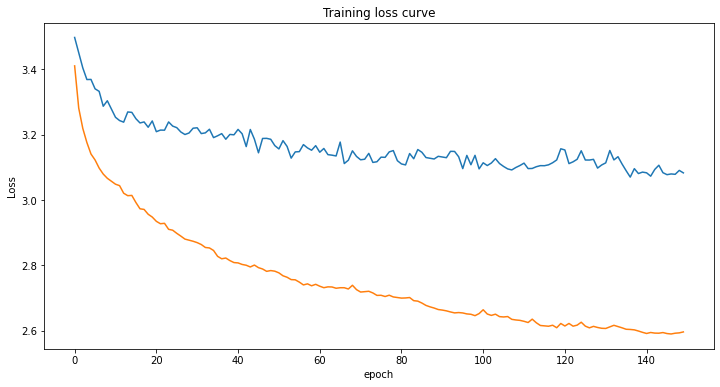

In [ ]:
import matplotlib.pyplot as plt
# training_total_loss = [ i.detach().numpy() for i in training_all_loss]
plt.figure(figsize = (12,6))
plt.plot(range(len(validation_all_loss)),validation_all_loss)

plt.plot(range(len(training_all_loss)),training_all_loss)
plt.xlabel("epoch")
plt.ylabel("Loss")
plt.title('Training loss curve')
plt.show()


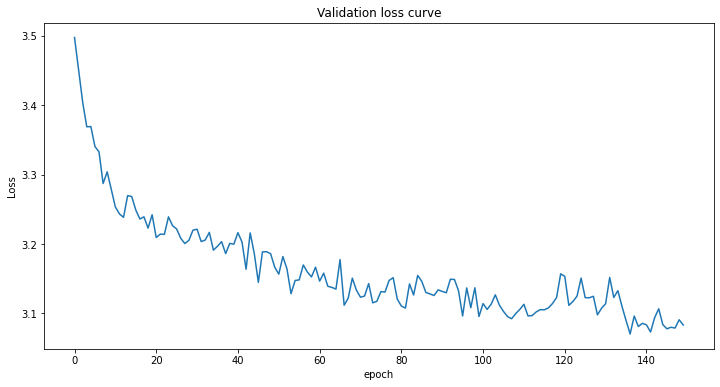

In [ ]:
import matplotlib.pyplot as plt
# validation_total_loss = [ i.detach().numpy() for i in validation_all_loss]
plt.figure(figsize = (12,6))
plt.plot(range(len(validation_all_loss)),validation_all_loss)
plt.xlabel("epoch")
plt.ylabel("Loss")
plt.title('Validation loss curve')
plt.show()

### Calculation of training and testing metrics: 
mIOU = mean Intersection over union<br>
maccuracy = mean accuracy of all classes<br>
Accuracy<br>

In [ ]:

import torchvision.transforms as T

        
def calculate_metrics(model):

    cal_metrics=calculate()
    model.to(device)
#     print("here")
    with torch.set_grad_enabled(False):
        model.eval()
#         print("here1")
        count=0
        for batch,labels in train_gen:
    #             print("here2")
            count+=1
            batch=batch.float().to(device)
#             batch = F.normalize(batch,mean=[0.485,0.456,0.406],std=[0.229,0.224,0.225])
            predictions=model(batch)
            predicted_masks=torch.argmax(predictions,dim=1).type(torch.float)
            labels = labels.squeeze(1).to(device)
            cal_metrics.add(predicted_masks.cpu(),labels.cpu()) 
        print("Training set: miou,maccuracy,accuracy: ",cal_metrics.calculate_accuracy())

    cal_metrics_=calculate()
    with torch.set_grad_enabled(False):
        model.eval()
#         print("here1")
        count=0
        for batch,labels in test_gen:
    #             print("here2")
            count+=1
            batch=batch.float().to(device)
#             batch = F.normalize(batch,mean=[0.485,0.456,0.406],std=[0.229,0.224,0.225])
            predictions=model(batch)
            predicted_masks=torch.argmax(predictions,dim=1).type(torch.float)
            labels = labels.squeeze(1).to(device)
            cal_metrics_.add(predicted_masks.cpu(),labels.cpu()) 
        print("Testing set: miou,maccuracy,accuracy: ",cal_metrics_.calculate_accuracy())

calculate_metrics(model)

Training set: miou,maccuracy,accuracy:  (0.6697031212142777, 0.7472485221855514, 0.9387725525732378)
Testing set: miou,maccuracy,accuracy:  (0.305307556448514, 0.4264752371152387, 0.6097066061837328)


### Testing Phase

We predicted the segmentation masks using our trained model.

In [ ]:
import torchvision.transforms.functional as F

testing_total_loss=0
testing_loss=0
model.to(device)
model.eval()
print("here")
All_predicted_test_masks = []
with torch.set_grad_enabled(False):
    print("here1")
    for batch,labels in test_gen:
#             print("here2")
        batch=batch.float().to(device)
        labels=labels.float()
        predictions=model(batch)
        predictions = predictions.type(torch.FloatTensor)
        npred = torch.argmax(predictions,dim=1)
        All_predicted_test_masks.append((batch,labels,npred))

here
here1


### Visualization of outputs.

Pallete to visualize 31 different classes

In [ ]:
import numpy as np
import matplotlib
import matplotlib.pyplot as plt
palette = np.array([[128,128,128],   # gray 0 other
                    [255,69,0],      # orange 1 crab
                    [0,100,0],       # green 2 crocodile
                    [255,102,255],   # white 3  dolphin
                    [128,0,128],     # purple 4 frog
                    [0,0,255],       # blue 5 nettles
                    [255,0,255],     # Magenta 6 octopus
                    [255,255,0],     # Yellow 7 otter
                    [0,255,255],     # Cyan 8 penguin
                    [128,0,0],       # maroon 9 polar_bear
                    [255,20,147],    # deep pink 10 sea_anemone
                    [139,69,19],      # saddle brown 11 sea_urchin
                    [0,128,128],     # Teal 12  seahorse
                    [128,128,0],     # Olive 13 seal
                    [218,165,32],    # golden 14  shark
                    [188,143,143],   # 	rosy brown 15 shrimp 
                    [64,224,208],    # turquoise 16 star_fish
                    [95,158,160],    # cadet blue 17 stingray
                    [219,112,147],   # Pale Violet Red 18 squid
                    [216,191,216],   # thistle 19 turtle
                    [189,183,107],   # 	dark khaki 20 whale
                    [135,206,250],   # light sky blue 21 nudibranch
                    [255,127,80],   # coral 22 coral
                    [192,192,192],   # silver 23 rock
                    [240,255,255],   # azure 24 water
                    [244,164,96],   # sandy brown 25 sand
                    [124,252,0],   # lawn green 26 plant
                    [255,228,181],   # moccasin 27 human
                    [176,196,222],   # light steel blue 28 ice berg
                    [75,0,130],   # indigo 29 reef
                    [  0,   0,   0]   # Black 30 fish          
                    ])  


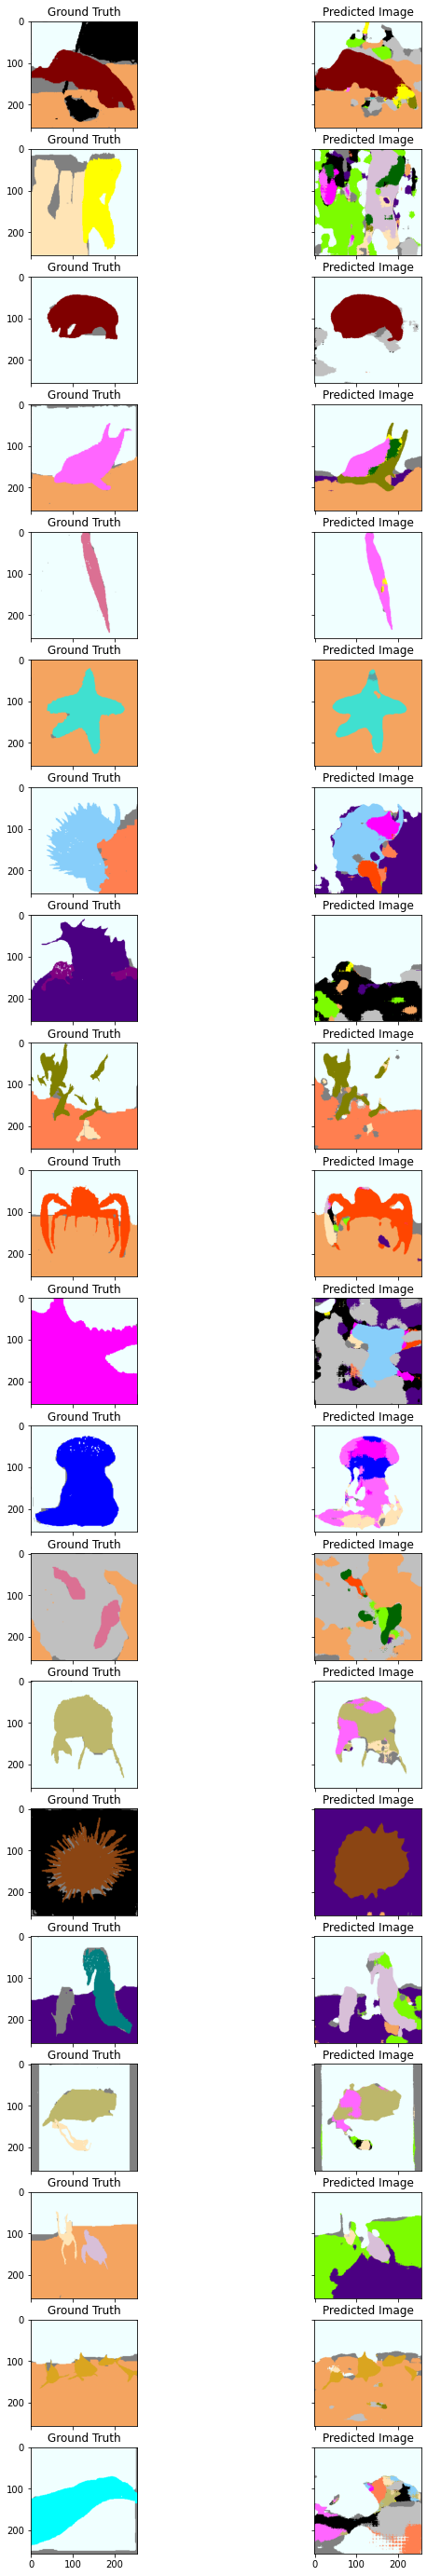

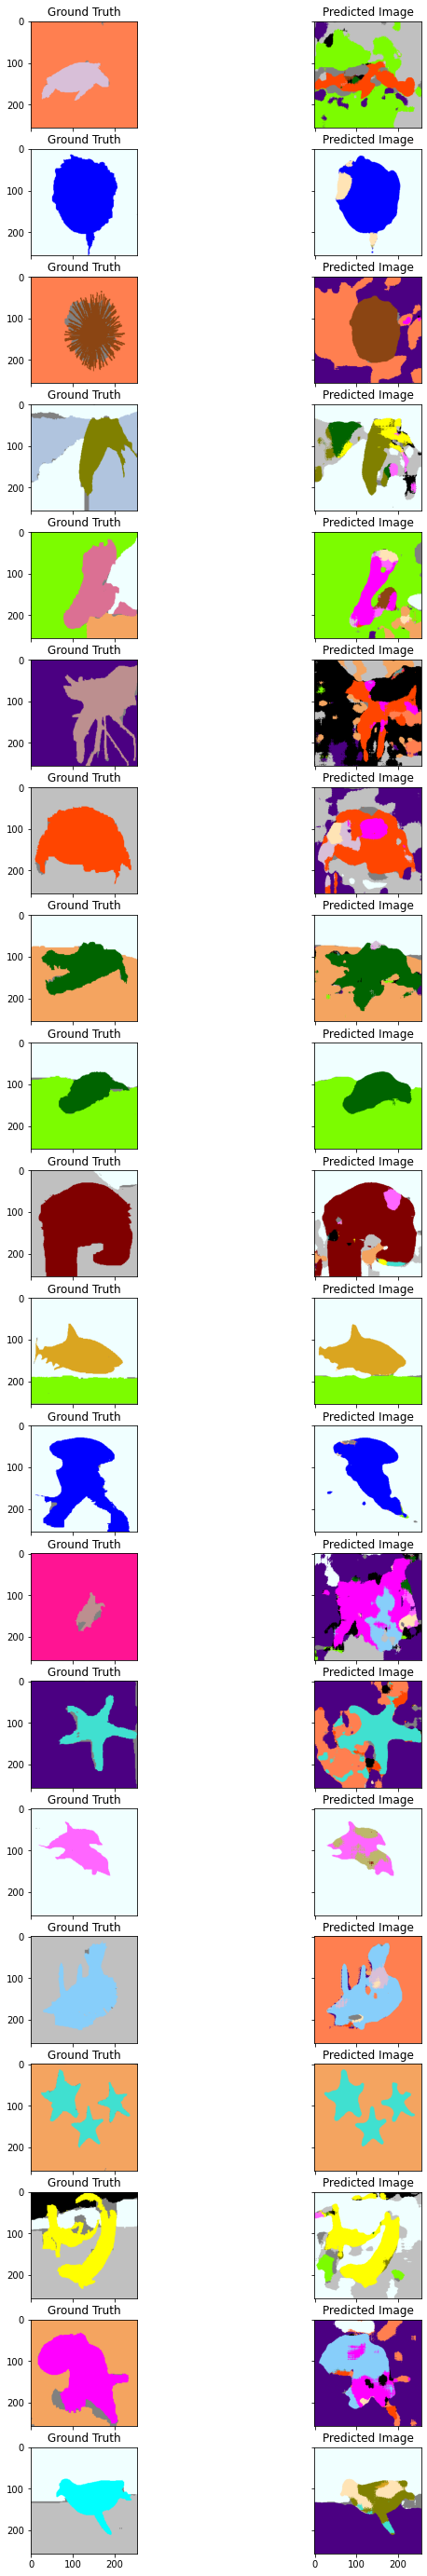

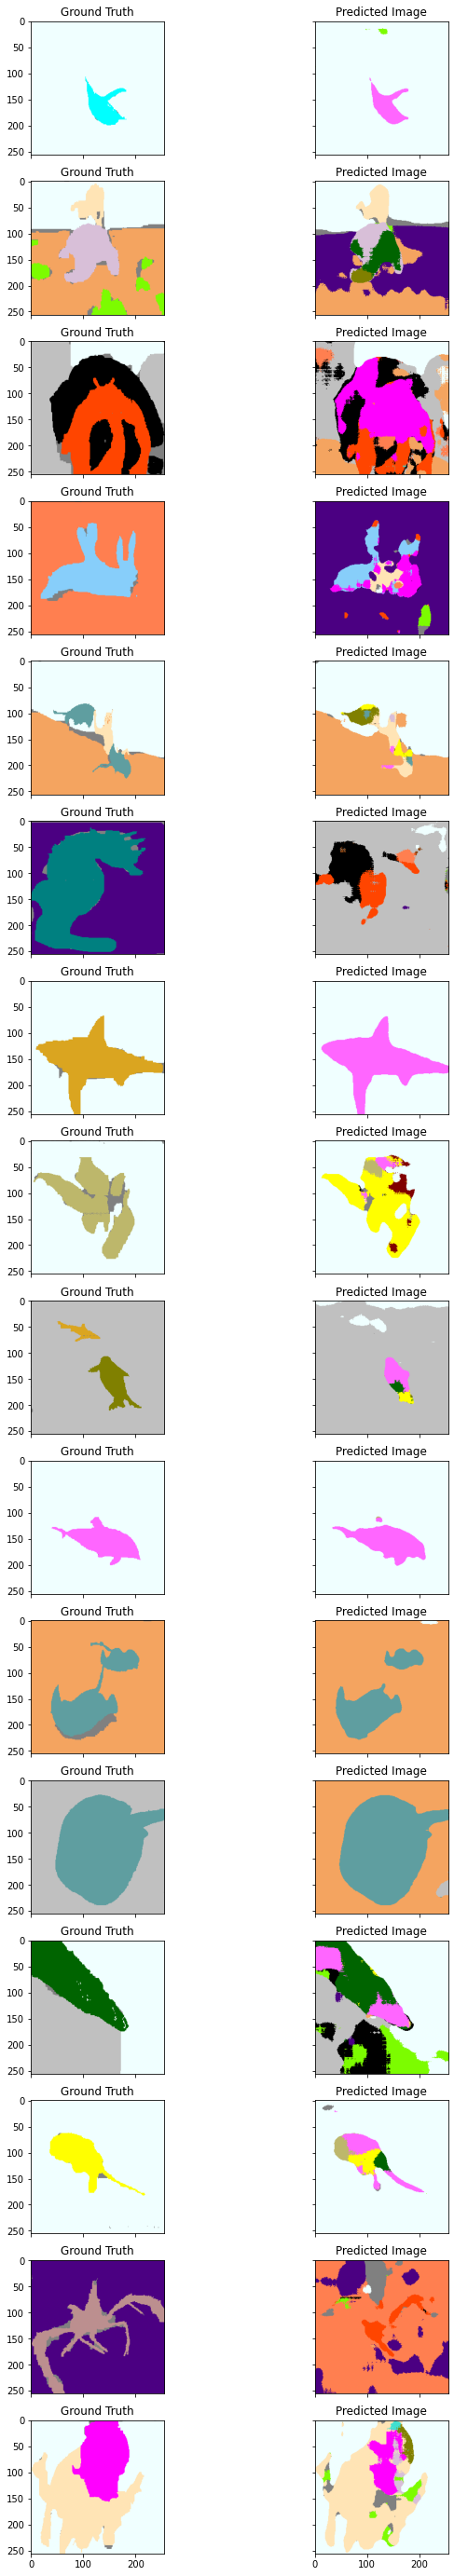

In [ ]:
import matplotlib
import matplotlib.pyplot as plt
def show(labels,npred,Image_number):

    cmap=matplotlib.cm.spring
    # print(len(npred))
    fix, axs = plt.subplots(nrows = len(npred) ,ncols=2,sharex=True, sharey=True, squeeze=False, figsize=(10,50))

    # fix.tight_layout()
    for i in range(len(npred)):
        #print(len(mask.detach().numpy()))
        #print(mask.detach().numpy().size())
        mask=npred[i].detach().numpy().astype(int)
        gt=labels[i].detach().numpy().astype(int)
        axs[i,0].set_title("Ground Truth")
        RGB = palette[gt]
        axs[i, 0].imshow(RGB)
        axs[i,1].set_title("Predicted Image")
        RGB = palette[mask]
        axs[i,1].imshow(RGB)
        

Image_num = 0
for batch,labels,npred in All_predicted_test_masks:
    show(labels,npred,Image_num)


Other links we reffered <br>
https://pytorch.org/vision/stable/generated/torchvision.models.segmentation.deeplabv3_resnet50.html#torchvision.models.segmentation.deeplabv3_resnet50 <br>
https://pytorch.org/vision/stable/auto_examples/plot_visualization_utils.html#sphx-glr-auto-examples-plot-visualization-utils-py